# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob

# Environment setup

In [15]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.append('C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\models11.13\\research\\object_detection') # ~/tensorflow/models/research/object_detection
sys.path.append('C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\darkflow\\darkflow-master') # ~/darkflow
print(sys.path)
from utils import label_map_util
from utils import visualization_utils as vis_util


['C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master', 'D:\\Anaconda3\\python37.zip', 'D:\\Anaconda3\\DLLs', 'D:\\Anaconda3\\lib', 'D:\\Anaconda3', '', 'D:\\Anaconda3\\lib\\site-packages', 'D:\\Anaconda3\\lib\\site-packages\\win32', 'D:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'D:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\models\\research', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\models\\research\\slim', 'D:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Alive\\.ipython', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\models11.13\\research\\object_detection', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\darkflow\\darkflow-master', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\models11.13\\research\\object_detection', 'C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\darkflow\\darkflow-master']


# Tensorflow Object Detection API

## Model preparation 

In [16]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [17]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
# MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = "C:/Users/Alive/Downloads/new/traffic-sign-detection-master/models/faster_rcnn_resnet_101/inference_graph/frozen_inference_graph.pb"

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "C:/Users/Alive/Downloads/new/traffic-sign-detection-master/scripts/gtsdb3_label_map.pbtxt"

NUM_CLASSES = 3
print(PATH_TO_CKPT)
print(PATH_TO_LABELS)

C:/Users/Alive/Downloads/new/traffic-sign-detection-master/models/faster_rcnn_resnet_101/inference_graph/frozen_inference_graph.pb
C:/Users/Alive/Downloads/new/traffic-sign-detection-master/scripts/gtsdb3_label_map.pbtxt


## Load a (frozen) Tensorflow model into memory

In [18]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [19]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [20]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [21]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.ppm'))
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

['C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00000.ppm', 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00001.ppm', 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00002.ppm', 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00003.ppm', 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00004.ppm', 'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images\\00005.ppm']


In [22]:
###

In [23]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 775 814 411 445


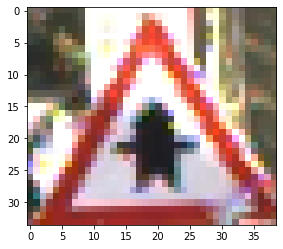

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00000.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 385 442 494 551


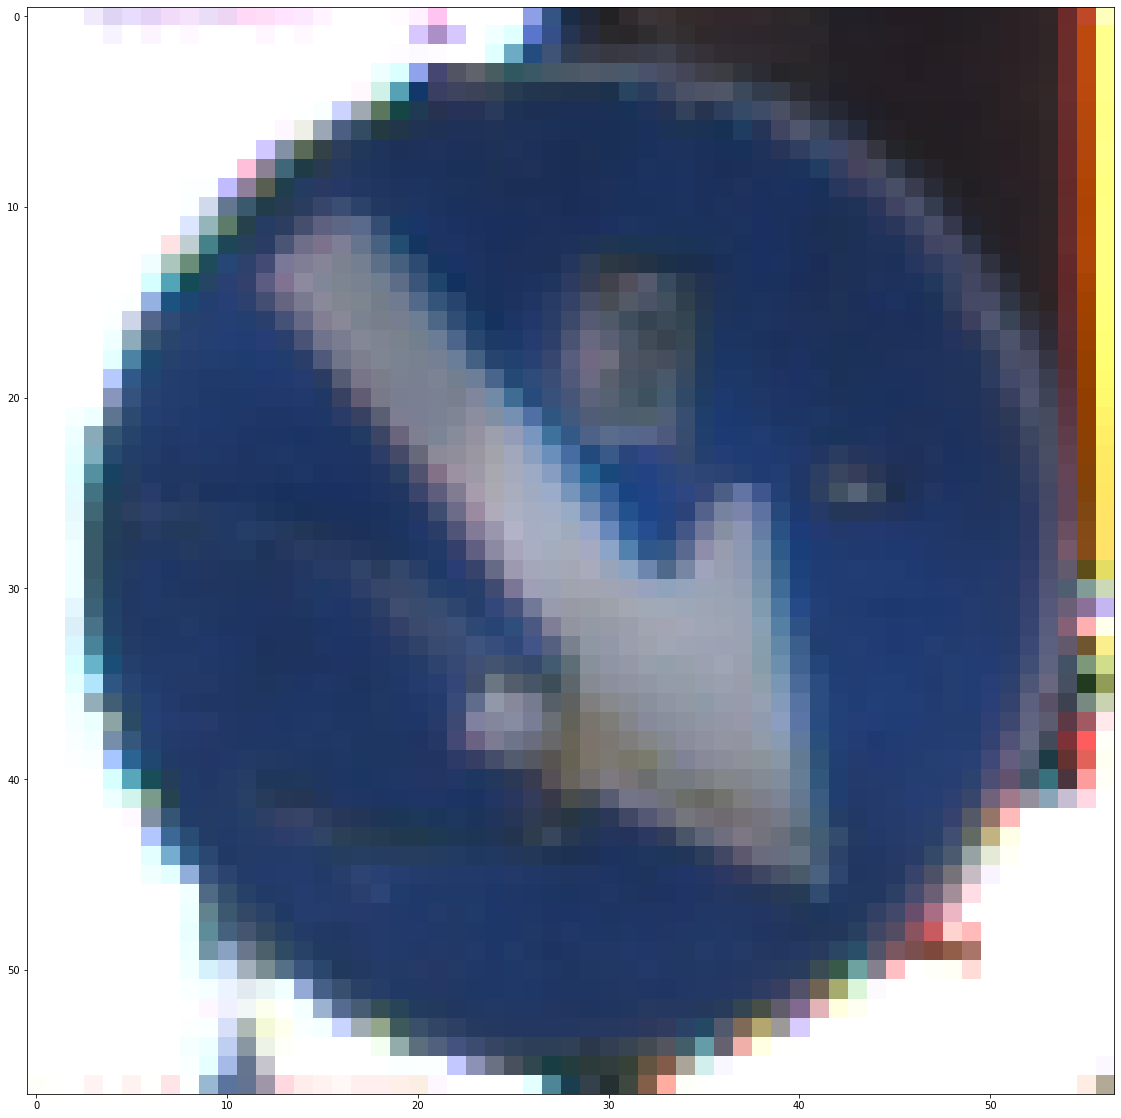

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 983 1024 388 432


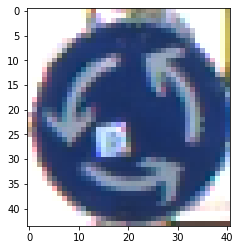

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00001.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 892 1005 475 592


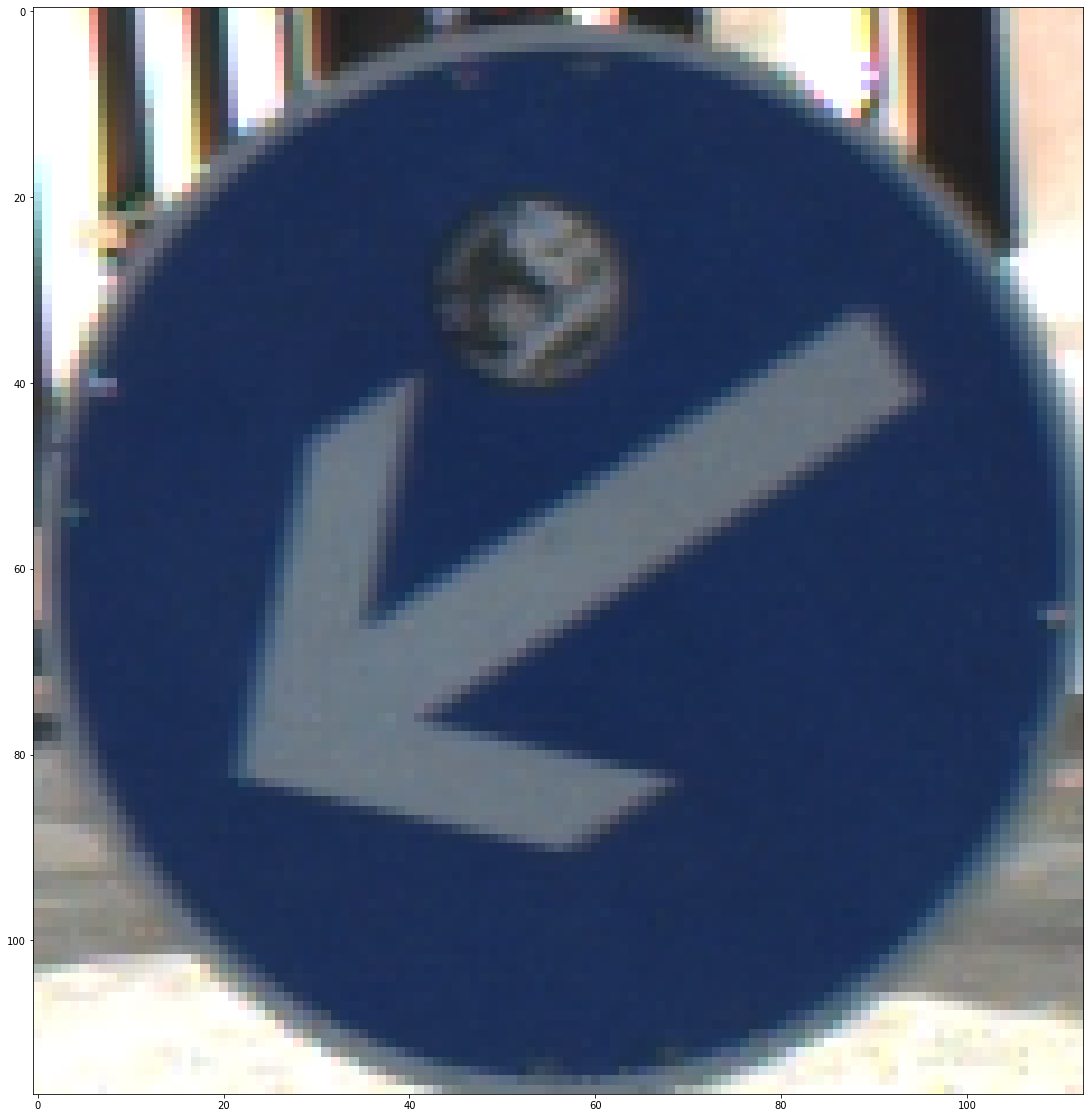

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00002.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 742 764 465 489


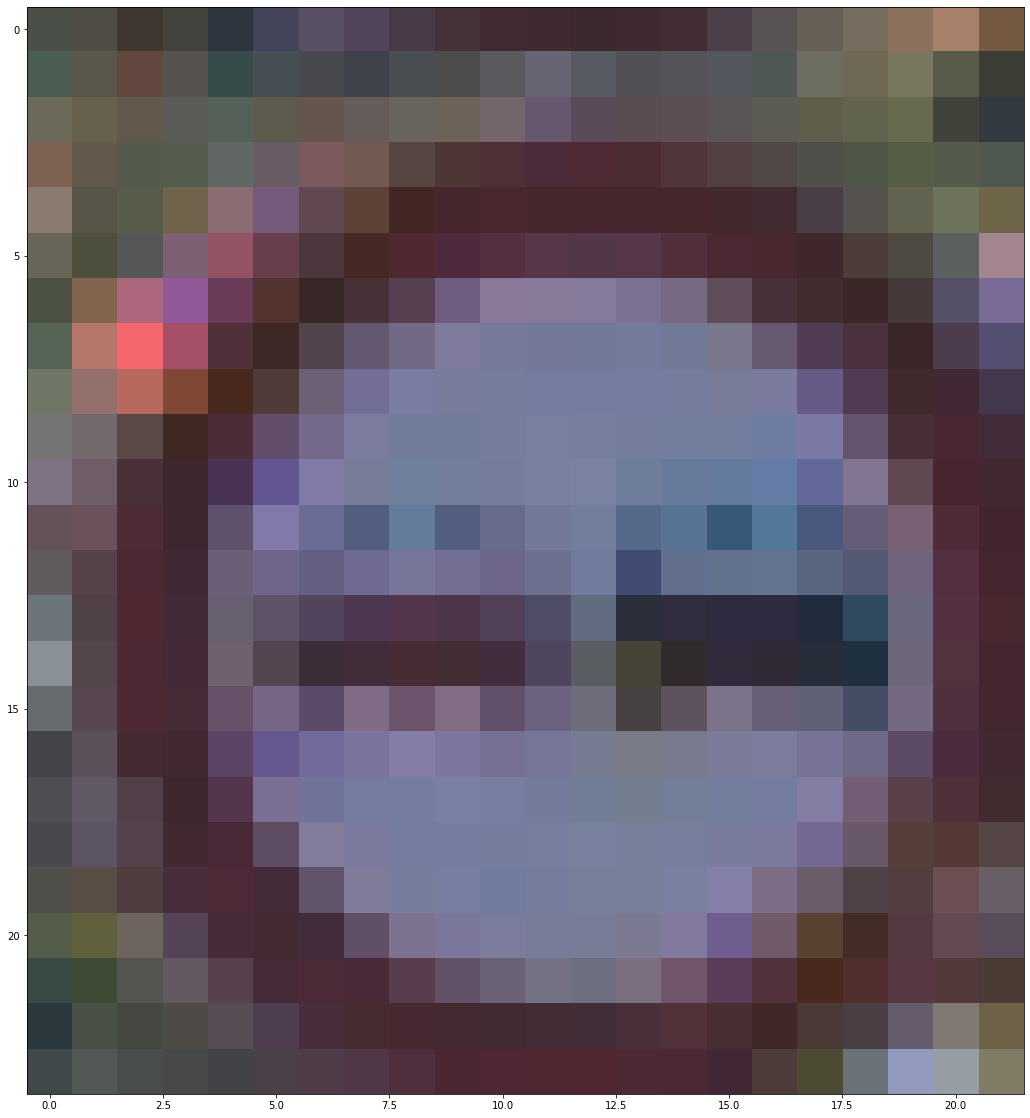

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 737 770 412 443


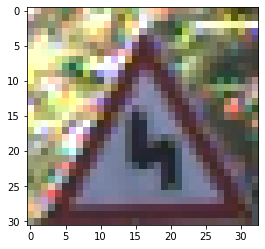

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 742 765 443 466


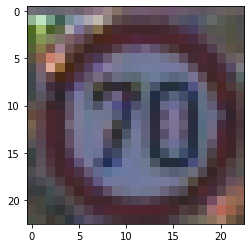

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00003.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 905 954 406 458


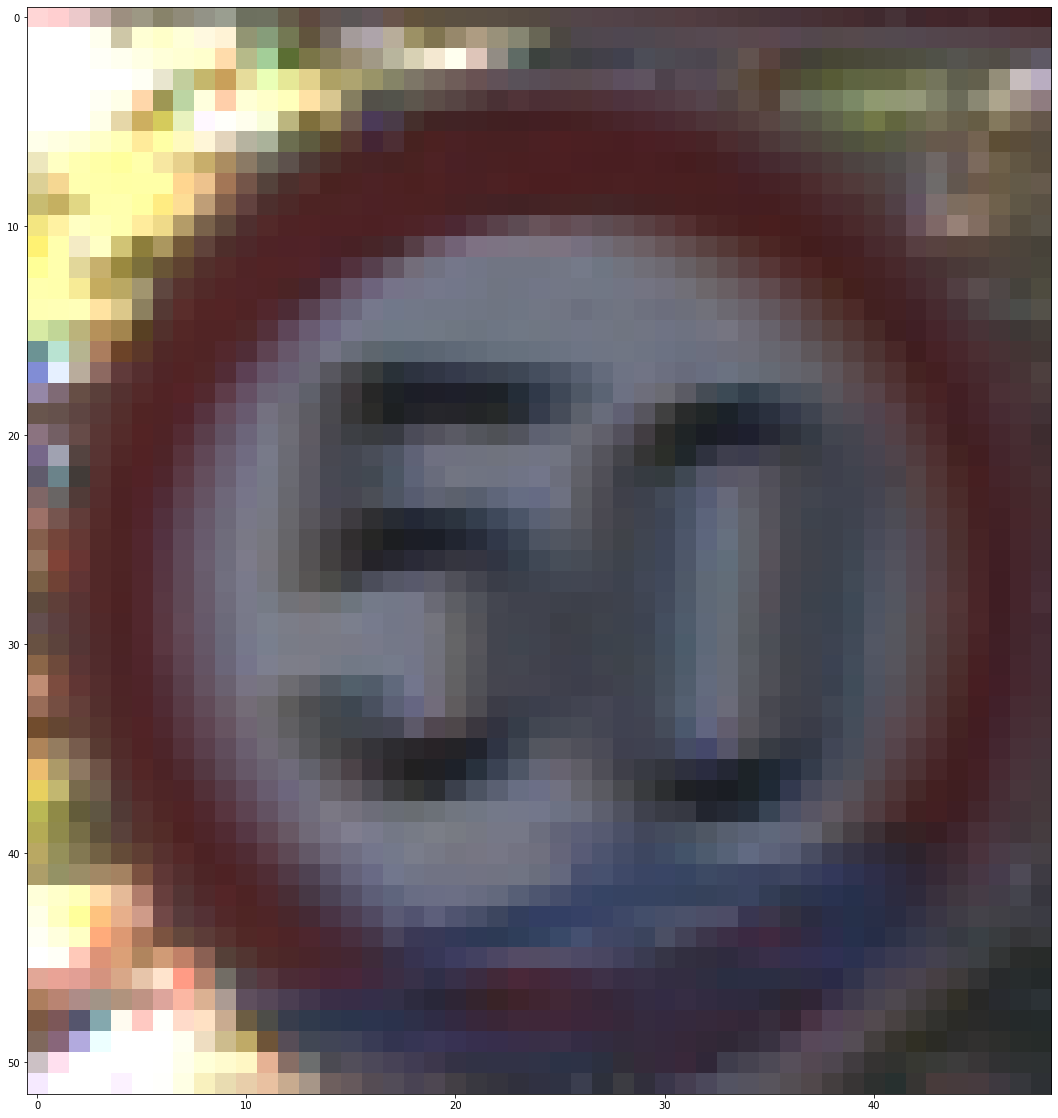

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 898 967 342 408


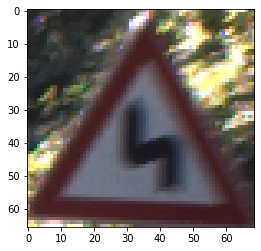

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00004.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 1170 1284 163 277


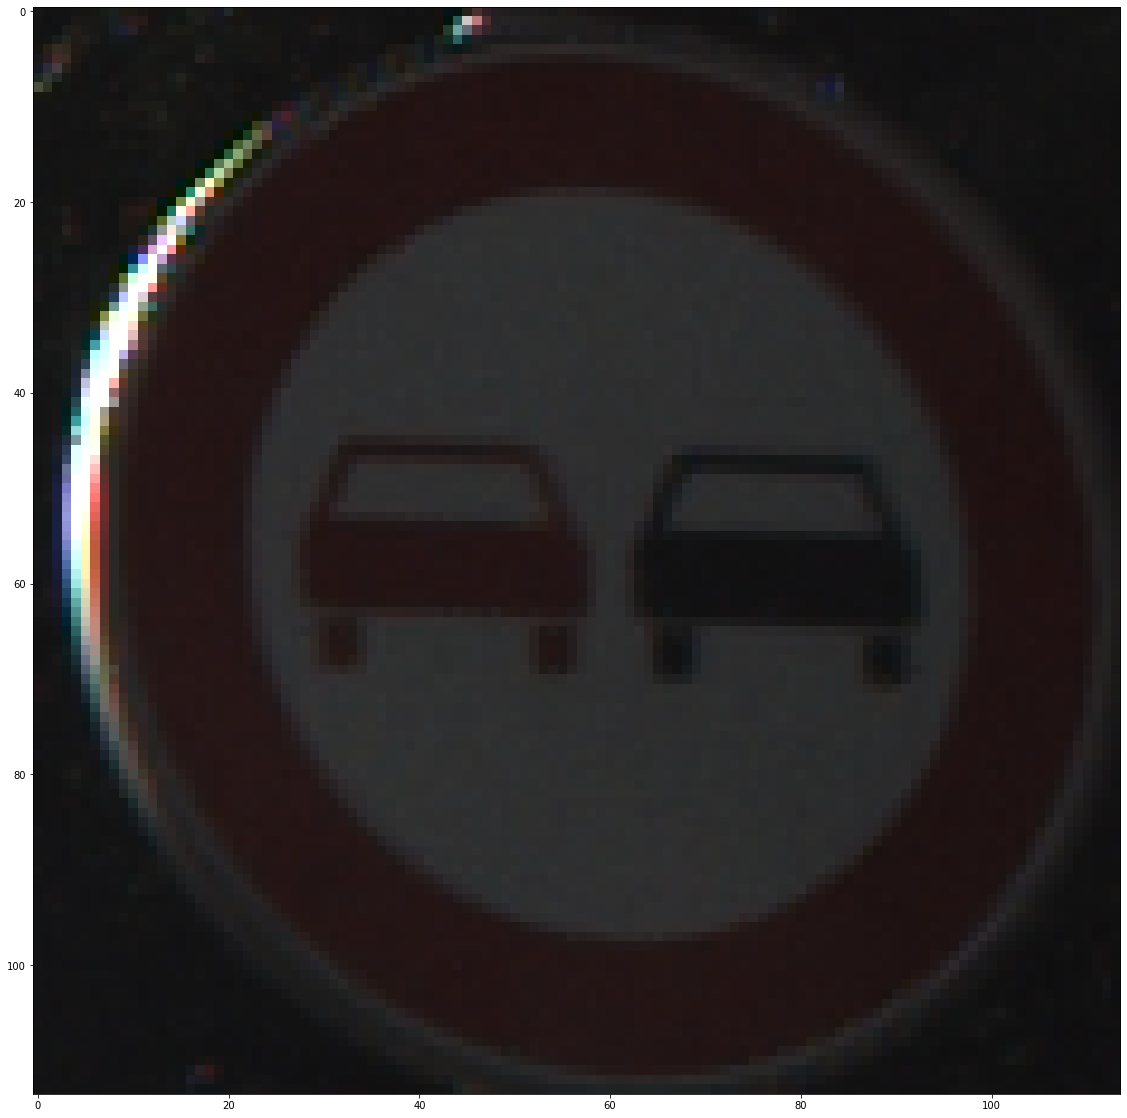

C:\Users\Alive\Downloads\new\traffic-sign-detection-master\test_images\00005.ppm


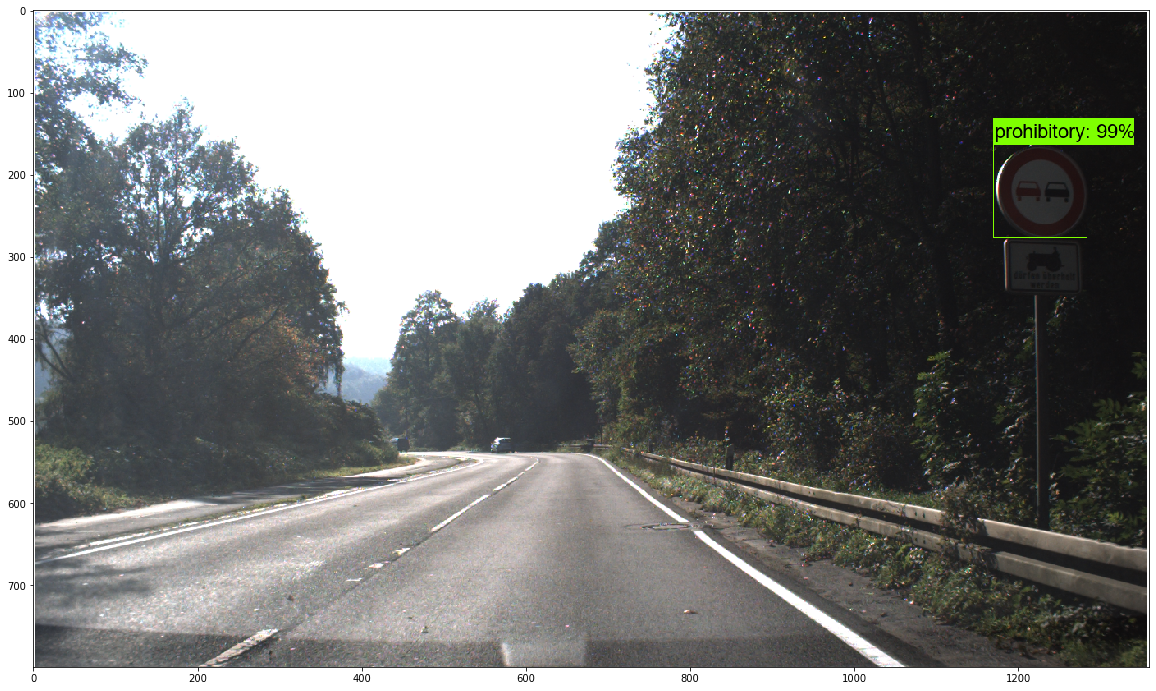

In [24]:
for image_path in TEST_IMAGE_PATHS:
    image= Image.open(image_path) #注意这里的image_path是个路径，也就是说是个字符串str，下文会用到
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      image_path, #原有的代码没有这一行，但是我需要传递测试图片image的文件名给visualize_utils文件中，所以加上，对应的visualize_utils中的visualize_boxes_and_labels_on_image_array函数也要加上这个参数
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1, #默认的框到粗细是8，但是实在太粗了
      )#the width of bounding box,default is 8
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    #save_dir = TEST_IMAGE_PATHS + '{}.jpg'.format(image_path)
    PATH_TO_TEST_IMAGES_1_DIR = r'C:\\Users\\Alive\\Downloads\\new\\traffic-sign-detection-master\\test_images' #这里可能要加上r，不然可能会有编码ucf8错误
    save_dir = os.path.join(PATH_TO_TEST_IMAGES_1_DIR, image_path)
    print(save_dir)
    vis_util.save_image_array_as_png(image_np,save_dir) #我将检测出来的图片保存在testsave_images文件夹下
     
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [25]:
###